# Baseline Model

Enable auto-reloading of external modules

In [15]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Import dependencies

In [16]:
from matplotlib import rcParams
from sys import getsizeof
from pprint import pprint

from utils.data_loader import *
from utils.null_handler import *
from utils.EDA_utils import *
from utils.simple_utils import *
from utils.model_tuning_utils import *
from config import *

import os
import warnings
warnings.filterwarnings('ignore')
os.environ["PYTHONWARNINGS"] = "ignore"

plt.style.use('mpl20')
matplotlib.rcParams['figure.dpi'] = 100

In [17]:
try:
    from folktables import ACSDataSource, ACSEmployment
except:
    !pip install folktables
    from folktables import ACSDataSource, ACSEmployment

## Loading ACSEmployment data

In [18]:
X_data_load, y_data = ACSDataLoader(task=DATASET_CONFIG['task'], state=DATASET_CONFIG['state'], year=DATASET_CONFIG['year'])

In [19]:
# If the task is ACSEmployment, we can optimize the file size
print(f'Original: {int(getsizeof(X_data_load) / 1024**2)} mb')
print(f'Optimized: {int(getsizeof(optimize_ACSEmployment(X_data_load)) / 1024**2)} mb')

X_data = optimize_ACSEmployment(X_data_load)

Original: 24 mb
Optimized: 12 mb


In [20]:
missing = ['SCHL', 'ESP', 'MIG', 'MIL', 'DREM']
X_data = initially_handle_nulls(X_data, missing)
# Rechecking if there are nulls -- if the null_handler has run correctly, there should not be
X_data.isnull().sum()

Dataset shape before handling nulls:  (196967, 16)
Impute values:  {'SCHL': 0, 'ESP': 0, 'MIG': 0, 'MIL': 0, 'DREM': 0}
Dataset shape after handling nulls:  (196967, 16)


AGEP        0
SCHL        0
MAR         0
RELP        0
DIS         0
ESP         0
CIT         0
MIG         0
MIL         0
ANC         0
NATIVITY    0
DEAR        0
DEYE        0
DREM        0
SEX         0
RAC1P       0
dtype: int64

## Tune hyper-parameters and find the best baseline model

Baseline X_train shape:  (157573, 16)
Baseline X_test shape:  (39394, 16)
X_train_features.columns:  Index(['MAR_1', 'MAR_2', 'MAR_3', 'MAR_4', 'MAR_5', 'MIL_0.0', 'MIL_1.0',
       'MIL_2.0', 'MIL_3.0', 'MIL_4.0', 'ESP_0.0', 'ESP_1.0', 'ESP_2.0',
       'ESP_3.0', 'ESP_4.0', 'ESP_5.0', 'ESP_6.0', 'ESP_7.0', 'ESP_8.0',
       'MIG_0.0', 'MIG_1.0', 'MIG_2.0', 'MIG_3.0', 'DREM_0.0', 'DREM_1.0',
       'DREM_2.0', 'NATIVITY_1', 'NATIVITY_2', 'DIS_1', 'DIS_2', 'DEAR_1',
       'DEAR_2', 'DEYE_1', 'DEYE_2', 'SEX_1', 'SEX_2', 'RAC1P_1', 'RAC1P_2',
       'RAC1P_3', 'RAC1P_4', 'RAC1P_5', 'RAC1P_6', 'RAC1P_7', 'RAC1P_8',
       'RAC1P_9', 'RELP_0', 'RELP_1', 'RELP_2', 'RELP_3', 'RELP_4', 'RELP_5',
       'RELP_6', 'RELP_7', 'RELP_8', 'RELP_9', 'RELP_10', 'RELP_11', 'RELP_12',
       'RELP_13', 'RELP_14', 'RELP_15', 'RELP_16', 'RELP_17', 'CIT_1', 'CIT_2',
       'CIT_3', 'CIT_4', 'CIT_5', 'ANC_1', 'ANC_2', 'ANC_3', 'ANC_4', 'SCHL',
       'AGEP'],
      dtype='object')
Tuning for LogisticRegres

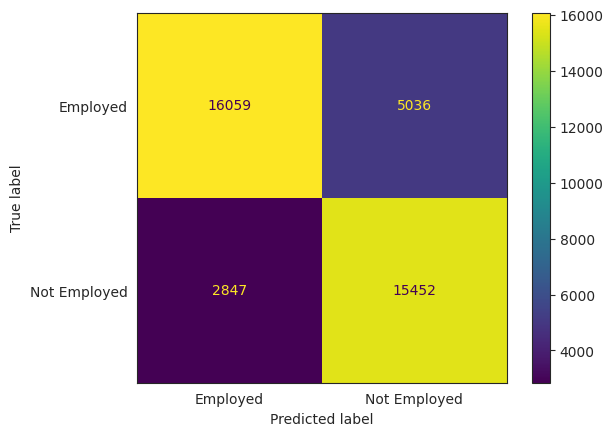

Tuning for DecisionTreeClassifier is finished
####################  Folktables [NY 2018]  ####################
Test model:  DecisionTreeClassifier
Test model parameters:
{'criterion': 'entropy', 'max_depth': 10, 'max_features': 0.6}

              precision    recall  f1-score   support

           0      0.870     0.787     0.826     21095
           1      0.779     0.864     0.819     18299

    accuracy                          0.823     39394
   macro avg      0.824     0.826     0.823     39394
weighted avg      0.828     0.823     0.823     39394



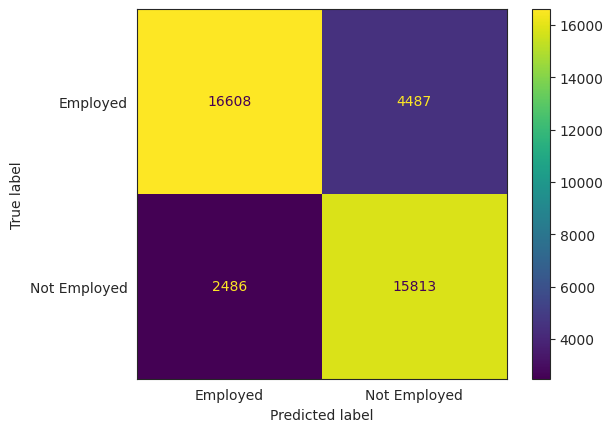

Tuning for XGBClassifier is finished
####################  Folktables [NY 2018]  ####################
Test model:  XGBClassifier
Test model parameters:
{'learning_rate': 0.1,
 'max_depth': 5,
 'n_estimators': 300,
 'objective': 'binary:logistic'}

              precision    recall  f1-score   support

           0      0.868     0.805     0.835     21095
           1      0.792     0.858     0.824     18299

    accuracy                          0.830     39394
   macro avg      0.830     0.832     0.830     39394
weighted avg      0.833     0.830     0.830     39394



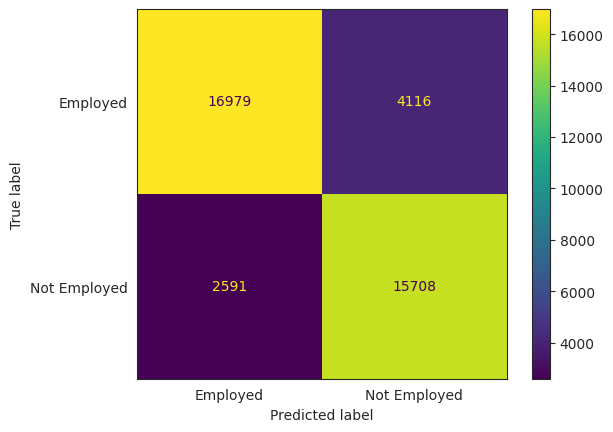

,Dataset_Name,Model_Name,F1_Score,Accuracy_Score,Model_Best_Params
0,Folktables [NY 2018],LogisticRegression,0.799846,0.799893,"{'max_iter': 100, 'penalty': 'l2', 'solver': '..."
1,Folktables [NY 2018],DecisionTreeClassifier,0.822921,0.822993,"{'criterion': 'entropy', 'max_depth': 10, 'max..."
2,Folktables [NY 2018],XGBClassifier,0.829568,0.829746,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti..."


In [21]:
# Copy datasets for tuning to avoid confusion with datasets for imputations
baseline_X_data, baseline_y_data = X_data.copy(deep=True), y_data.copy(deep=True)

ML_baseline_results_df = test_baseline_models(baseline_X_data, baseline_y_data, COLUMN_TO_TYPE['categorical'], COLUMN_TO_TYPE['numerical'])
ML_baseline_results_df

In [22]:
for index, row in ML_baseline_results_df.iterrows():
    print(f'\n\nModel name: {row["Model_Name"]}')
    pprint(row['Model_Best_Params'])



Model name: LogisticRegression
{'max_iter': 100, 'penalty': 'l2', 'solver': 'saga'}


Model name: DecisionTreeClassifier
{'criterion': 'entropy', 'max_depth': 10, 'max_features': 0.6}


Model name: XGBClassifier
{'learning_rate': 0.1,
 'max_depth': 5,
 'n_estimators': 300,
 'objective': 'binary:logistic'}


In [23]:
ML_baseline_results_df.to_csv(os.path.join('..', 'results', f'ML_baseline_results_df.csv'),
                              sep=",", columns=ML_baseline_results_df.columns, float_format="%.4f")